In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# importanting necessary to solve image classification problem


In [39]:
"""
Now that we have all the necessary libaries for our problem, we
need to load in our data. The data we will be importing will
be 32 x 32 pixel colored images of vehicles and animals. The volume of 
training data is 50,000 colored images and 10,000 testing images.
Let's load in the data and dive into what will be fed into the model
"""

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

training shapes: x: (50000, 32, 32, 3), y: (50000, 1)
testing shapes: x: (10000, 32, 32, 3), y: (10000, 1)
[4]


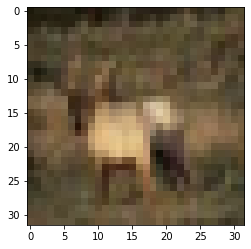

In [42]:
"""
With the data sucessfully loaded, let's take a look 
at the shape of the data as well as what it actually 
looks like to a human. For verification, our shapes should
match up with our preivous claim above along with rgb values
on the x datasets and classifications for the y datasets. Our data input
data should also be e dimensions because of the RGB values of them.
"""
print(f"training shapes: x: {x_train.shape}, y: {y_train.shape}\ntesting shapes: x: {x_test.shape}, y: {y_test.shape}")

plt.imshow(x_train[0]) # looks like our first peice of data is a frog
print(y_train[0]) # looks like our first peice of data is a frog




In [89]:
"""
With the images read in let's consider how they 
will be processed into a model. Since the images are not
that big in size (32x32 pixel), they do not need
to be re-sized, although the images are colored. One
thing I want to consider is gray scaling the images
to make processing less complex. In order to do this
I need to apply the weighted sum to each image.
"""

def process(images):
    data = [] # new array tp hold gray scale images
    # images = images / 255.0 # normalizing every image between 0 and 1
    gamma = 1.04 # color gamma correction factor (smoother color transitions)
    r_cst, g_cst, b_cst = 0.2126, 0.7152, .0722 # constants for red, green, and blue gray scale conversion factor
    for img in images:
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2] # each rgb value for the image
        data.append((r_cst * r ** gamma) + (g_cst * g ** gamma) + (b_cst * b ** gamma))
    return np.array(data)



In [ ]:
x_train, x_test = process(x_train), process(x_test)

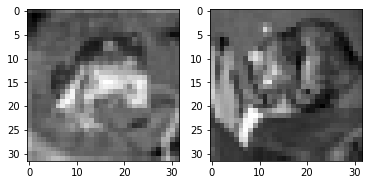

In [90]:

"""
Looks like our images are now grey scaled with their
rgb values averaged based on their weighted luminance.
Here is a quick representation of what our new data looks
like as well as the values with in the image array.
With the elimination of our rgb values, our images are no
longer 2 dimensions but 3. We can see this with the new shapes
"""


f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train[0], cmap=plt.cm.get_cmap("gray"))
f.add_subplot(1,2, 2)
plt.imshow(x_test[0], cmap=plt.cm.get_cmap("gray"))
plt.show(block=True)



In [14]:
"""
With the data now ready to go, let's build
a baseline model that can give us an idea on 
how to solve our image processing problem. I find
Tensorflows keras library to be the most intuitive
and the most powerful of all the Machine Learning
libraries so I will use that libarary and it's 
parameters to build a base. 
"""

from tensorflow.keras import Sequential # model to stack layers
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard

"""
Since the problem is image classification, building a 
Convolutional Neural Network is probably the best for this
problem. Keras has some classes from the layers class
that will help us create a CNN, so I will use those 
as well as some other classes that will help us later on.
Finally, I will use Tensorboard to help me visual the 
metrics of the model on a plot.

Before we go into developing that, let's normalize the data
and prepare a baseline model to compare to our CNN models.
All we have to do is divide by the max range of of pixel values
to obtain a value between 0 and 1
""";





In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0
print(f"new training point:\n{x_train[0]}\nnew test point:\n{x_test[0]}")

In [92]:
"""
Now that we have the data, we can begin building our baseline
model. Since the the images are fed forward sequentially, we will
be using the sequential model. First, I will initialize it then
add features that will allow it to be trainable
"""

baseline = Sequential() # init

In [93]:
"""
With the model created, let's start adding 
functionality to it. Since the model is baseline
I will keep it simple to get us in the right direction
for building a real Convolutional Neural Network.

Because the images are 2D, I will modify them so every pixel in the image represents one single
input neuron. The Flatten layer helps do this.

Next I want a single hidden layer of neurons with an activation function that will help learn
the 1024 (32x32 flattened) inputs. I will add a Dense (fully connected layer) layer with 128 neurons
outputing a value from the inputs. For the activation, I will choose rectified linear because of it's
convergence advantages and speed

Lastly, I will add our output layer which will fire a neuron based on the highest value between all neurons
in the output layer. Since we have 10 classes, I will be using an output layer of 10 neurons and an activation
of softmax which helps precisely determine the neuron of highest activity to fire.
"""

baseline.add(Flatten(input_shape=(32, 32))) # flattening image from 2D -> 1D 1024 Input Layer
baseline.add(Dense(128, activation="relu")) # 128 Hidden Layer relu
baseline.add(Dense(10, activation="softmax")) # 10 Output Layer softmax

baseline.summary() # network pipline



Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_66 (Flatten)        (None, 1024)              0         
                                                                 
 dense_102 (Dense)           (None, 128)               131200    
                                                                 
 dense_103 (Dense)           (None, 10)                1290      
                                                                 
Total params: 132,490
Trainable params: 132,490
Non-trainable params: 0
_________________________________________________________________


In [94]:
"""
With the model built let's begin to compile it towards a goal.
For the optimizer (how the model learns) I will use adam. I chose
adam because of it's efficiency and commonly with a large amount of
parameters. 

For the loss function, I will use Categorical Cross Entropy. This
computes the cross entropy from our prediction and the target of a given data point
and is good for multi-class error minimaztion. Since our labels are integer and not
one-hot, I will use the Sparse algorithm for the base model and all models because 
our desired output remains as multi-classification.

Lastly, I will choose the base accuracy for all models since all we want is the total
correct over the total data it has been given. 

After compilation, let's fit and evaluate the model using some model methods built-in.
I'm going to keep it minimal and go with 10 epochs which should be a valid amount of times
for the model to learn something but not try to fit to well to the training data.
"""

baseline.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
baseline.fit(x_train, y_train, epochs=10)
loss, accuracy = baseline.evaluate(x_test, y_test)
print(f"Validation Loss: {loss}\nValidation Accuracy: {accuracy*100}%")


Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 2.0497 - accuracy: 0.2531
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.9205 - accuracy: 0.3136
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8680 - accuracy: 0.3353
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8375 - accuracy: 0.3473
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8153 - accuracy: 0.3535
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7974 - accuracy: 0.3614
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7829 - accuracy: 0.3654
Epoch 8/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.7694 - accuracy: 0.3697
Epoch 9/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7588 - accuracy: 0.3747
Epoch 10/10
313/313 [==============================] - 1s 3ms/step - loss: 1.7805 

In [95]:
# example prediction
print(f"Prediction: {np.argmax(baseline.predict(x_test)[0])} True: {y_test[0][0]}")


Prediction: 4 True: 3


In [32]:
"""
With the model evaluated, it is most certainly
not a good a idea to maintain these metrics for
real world use. The baseline model has an accuracy
in the 35-40 percent range and struggles to minimize
loss as it goes through epoch the epochs.

Some things I'm considering for the two fine tuned models
are amount of hidden layers, neurons in them, 
and potentially changing the learning rate of our optimizer or
the optimizer entirely to see if that helps learning.

Something I learned when flattening the images is that I lose
the positional information of pixel. To eliminate this
I need to intro convolutional layers which will help
me maintain that information, extract features from them, and
hopefully help the model learn the image for classification. Then,
I should be able to flatten those features to our output layer
for classification.

Lastly, something I didn't do previous was consider the batch size
when fitting. During the process of building the 2 models, I will
try different batch sizes to see which size has a better peformance
metric on our validation data.
"""

pass



In [33]:
"""
For our first tuned model lets build a 
sequential model that adds convolutional layers
to some of the Hidden layers. 

One reason to include convolutional layers is to learn
features of the images. This is extremely important because
of the amount of inputs in a single image. In this example, there
are 1024 parameters which means as we add more hidden layers and
neurons in the hidden layers, the amount of trainiable weights grows
by a factor which can lead to over-fitting on a dataset and it's also 
computationally intensive, especially for my laptop.

One thing a convolutional layer does is provide a kernal from edge-to-edge
on an image. This kernal is basically the weights and a bias for an image peice. 
Using convolutional operations between a space on an image and a kernal 
of our image, we can obtain a single value. We can then apply some activation
function to this value. In total, this elimates the large amount of weights
and allows the extraction of features in an image to help us learn. For every kernal
we apply to the image, we create feature maps of the image. This is important because
we can apply what is known as max pooling which allows to obtain the most intense
values for inputs to next layers. Lastly, we can stack kernals to create filters which
allows us to have multiple feature maps. Since we're working with 10 classes of images
we will need filters.

In combination of convolutional layers and pooling layers, we should see some peformance 
increase in our model when we train and validate it using our datatsets.
"""

pass

In [42]:
"""
For my first fine tuned model, I am getting the idea to
have two convolutional layers and two max pooling layers.
My ideology behind this is to create multiple feature maps
based on our filters then to pool the most important features 
from those features maps. I then one to repeat the process 
again on those pooled feature maps to extract further features 
from the images. Lastly, I will then flatten the outputs of the last
pooled feature maps to give our output layer the ability to apply
the softmax activation on 1D data.

The first convolutional layer will take our 32x32 images with 1 channel
and apply 32 3x3 kernals (filter) to the image. We will then apply the relu
activation function to those convolved values to create a cube like structure 
of those values, 30x30x32 precisely. We will then downscale the 32 feature maps
by getting the highest intensity value over a 2x2 window. This will give us 
a 32 15x15 pooled feature maps. I will repeat the process except the output
of the next convolutional layer will be a 13x13x32 cube and the pooled features
will be 32 6x6 pooled feature maps. 

Now that we extracted some important features, I will flatten those outputs
to make the information one dimensional. Once the outputs from the feature maps
are flattened we can then pass them to the softmax output layer to get a vector
of probabilities that indicate what class the input belongs to.

Already looking at the summary of our baseline model to our first tuned model, our
trainable parameters is roughly 6x less which should really optimize training
"""
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), input_shape=(32, 32, 1), activation="relu")) # Input -> Conv Layer 32 3x3 filter relu -> Feature Maps
model_1.add(MaxPooling2D(pool_size=(2, 2))) # Feature Maps -> Pooled Feature Map over 2x2 window
model_1.add(Conv2D(32, (3, 3), activation="relu")) # Pooled Feature Maps -> Conv Layer 32 3x3 filter relu -> Feature Maps
model_1.add(MaxPooling2D(pool_size=(2, 2))) # Feature Maps -> Pooled Feature Map over 2x2 window 
model_1.add(Flatten()) # Flattening Pooled Feature Map values
model_1.add(Dense(10, activation="softmax")) # Output Layer softmax
model_1.summary()



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 1152)              0         
                                                                 
 dense_43 (Dense)            (None, 10)              

In [43]:
"""
With the model ready to go, lets compile it, then fit it to our
training data. I will use the same compilation parameters as before
for now to see how this model does.

I will also maintain the same amount of epochs as for the previous
fit parameters of the base model
"""

model_1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model_1.fit(x_train, y_train, epochs=10)
loss, accuracy = model_1.evaluate(x_test, y_test)
print(f"Validation Loss: {loss}\nValidation Accuracy: {accuracy*100}%")




Epoch 1/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.6668 - accuracy: 0.4137
Epoch 2/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3503 - accuracy: 0.5369
Epoch 3/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.2396 - accuracy: 0.5776
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1729 - accuracy: 0.6016
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1222 - accuracy: 0.6179
Epoch 6/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.0892 - accuracy: 0.6295
Epoch 7/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0594 - accuracy: 0.6393
Epoch 8/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0326 - accuracy: 0.6484
Epoch 9/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0091 - accuracy: 0.6568
Epoch 10/10
313/313 [==============================] - 1s 3ms/st

In [40]:
print(f"Prediction: {np.argmax(model_1.predict(x_test)[1])} True: {y_test[1][0]}") # example prediction


Prediction: 1 True: 8


In [37]:
"""
With the model evaluated, we are moving in the right direction when it comes
to predicting the correct classification on a given image. It appears that
adding convolutional layers and pooling features from the feature maps created
from convolutional layers yields much better accuracy metrics than our baseline
model. The loss is noticably lower than the baseline model (lower means better) 
and our accuracy has almost doubled from 35-40 percent range to the 60-70 percent
range.

These are great leaps for our goal of maximizing our accuracy on the model. 
With this first tuned model, I definitely want to take away some settings
for creating our final tuned model. 

I think the pairing of convolutional layers with max pooling layers to be a great
layout for the model. Although, I do want to consider changing some settings with in
the layers. Some things I want to consider is the amount of kernals I use on a given
filter. Perhaps trying 16, 64, or 128 etc. I also want to consider padding when
we create feature maps and pooled feature maps. Padding will give us the ability
to keep a feature map the same size as its input or allow us to enlarge it. Perhaps 
doing this will help learning features of an image. 

Another aspect I want to touch on is adding more Dense (fully connected) layers
to the model. In my first fine tuned model, we only have one dense layer which is
the output layer after the pooled feature maps are flattened. Maybe introducing 
a dense layer before the output layer with some activation function, probably relu,
will allow us to get the last extraction of learning the 1 dimensional data before 
it hits the softmax output layer. Also, it may help to work with different neurons 
in that dense layer as well.

Finally, I want to touch on different parameters for the compilation of our model
settings as a well as different fit settings. Perhaps changing our optimizer will
help us towards our learning goal (sgd, rmsprop, etc.) or changing the learning rate 
itself to help us towards our learning goal. For fitting, I think working with 
different batch sizes will help when it comes to optimizing training time as well
as learning. """

pass

In [48]:

"""

To automate the process of fine tuning this last model. I will create a function 
that creates different models with different settings. I will then evaluate the model
using the testing dataset we created.

The first parameters I want to play around with are the amount of convolutional layers 
and adding (a) dense layer(s) after the max pooled features are flattened.
I'm hoping and hypothesizing that adding dense layers after the feature maps are flattened
will eak out some more learnable parameters. To this, I will also add a dropout layer for each 
dense layer added before the output layer. In short dropout layers drop inputs at some rate which is good
because it allows the model to learn different parameters rather than just one entire training point. This is
good to prevent over-fitting of the data. I think the dropout layers may yield better testing 
validation accuracy so I want all inputs dropped at some rate (20% may change) as they pass through the
dense layer(s) before it hits the output layer.

I am going to test a maximum of 3 convolutional layers and a maximum of 2 dense layers that proceed. 
The very base model will have zero dense + dropout layers and a single convlutional + max pooling layer.
The featuremaps created between layers will remain 32 and the neurons will also remain 32. the batch
size as it learns will be 64 which I find to be a good sweet spot for learning our parameters but this
can change as we progress
"""

Dense_layers_added = [0, 1, 2] # up to 2 or 0 total dense + dropout layers
Conv2D_layers_added = [0, 1, 2] # up to 3 or 1 total convolutional + max pooling layers

def create_models():

    models = []

    # trying every possible dense layer added last

    for Dense_layer in Dense_layers_added:

        # trying every additional convolutional layers added next

        for Conv2D_layer in Conv2D_layers_added:

            # trying every possible neuron (feature maps) amount first

                
                # model settings and peformance
                print(f"{'-' * 60}\nDense layers: {Dense_layer}, Convolutional layers: {Conv2D_layer + 1}\n{'-'* 60}")

                model = Sequential() # initializing model

                model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 1), activation="relu")) # adding base conv2D (remains constant for inputs)
                model.add(MaxPooling2D(pool_size=(2, 2))) # add MaxPooling

                # adding i amount of additional convoluted layers with the same setup (different amount of feature maps)
                for i in range(Conv2D_layer):
                    model.add(Conv2D(32, (3, 3), activation="relu"))
                    model.add(MaxPooling2D(pool_size=(2, 2)))

                model.add(Flatten()) # flattening pooled featuremaps

                # adding j amount of dense & dropout layers with the same setup (different neurons)
                for j in range(Dense_layer):
                    model.add(Dense(32, activation="relu"))
                    model.add(Dropout(0.2))
                
                model.add(Dense(10, activation="softmax")) # adding our output layer with softmax

                model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # compiling with constant settings
                
                model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=0)
                loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
                print(f"Peformance\n{'-'* 60}\nloss: {loss} accuracy: {accuracy * 100}%\n{'-'* 60}")

                # adding model to all our models to evaluate them (above the 60% accuracy threshold)
                if accuracy >= 0.6:
                    models.append((model, Conv2D_layer, Dense_layer, loss, accuracy))

    return models


testing_models = create_models()



------------------------------------------------------------
Dense layers: 0, Convolutional layers: 1
------------------------------------------------------------
Peformance
------------------------------------------------------------
loss: 1.208613395690918 accuracy: 58.66000056266785%
------------------------------------------------------------
------------------------------------------------------------
Dense layers: 0, Convolutional layers: 2
------------------------------------------------------------
Peformance
------------------------------------------------------------
loss: 1.1549197435379028 accuracy: 61.19999885559082%
------------------------------------------------------------
------------------------------------------------------------
Dense layers: 0, Convolutional layers: 3
------------------------------------------------------------
Peformance
------------------------------------------------------------
loss: 1.143257737159729 accuracy: 60.75999736785889%
-------------

In [52]:
"""
Now that we have the models created, we can sort the models in ascending order
based on the validation accuracy and then pluck that model as the best model
over our test run.

After previewing some of the settings, I'm surprised to see some models get through and some models not get through. 
After further consideration a think a good model has 2-3 conv2D + MaxPooling layers and 0-1 Dense + Dropout layers. 
Some models may have converged better than others on a given run so I won't be too picky and choose the absolute best
validation accuracy in this list
"""

testing_models = sorted(testing_models, key=lambda x: x[-1])

print(testing_models) # sorted overview in ascending




[(<keras.engine.sequential.Sequential object at 0x7f801a4737f0>, 2, 2, 1.149789571762085, 0.6017000079154968), (<keras.engine.sequential.Sequential object at 0x7f8119ab9730>, 2, 0, 1.143257737159729, 0.6075999736785889), (<keras.engine.sequential.Sequential object at 0x7f80b009a5b0>, 1, 0, 1.1549197435379028, 0.6119999885559082), (<keras.engine.sequential.Sequential object at 0x7f80dc2a9100>, 1, 2, 1.1543594598770142, 0.614799976348877)]


In [53]:
"""
Now that we have a good idea of what layers to have to the model, let's
consider some other model settings that we can change. One thing I think will help
change and benefit our model is the amount of neurons in the dense layer as well
as how many feature maps are created as they pass through the convolutional and max pooling
layers. 

While testing this, I will also test the padding as valid vs padding as same. The 
padding will affect the output of the filter when its applied to the image. It will either 
keep image the same or downscale the image for the settings for the layers I have created.
Perhaps keeping the output from the convolutional layer through the filter the same
before features are pooled is better than decreasing the size from the edges and corners
of the image not completely hitting the filter. 
"""

neurons = [32, 64, 128] # 32 - 128 neurons
padding_settings = ["valid", "same"] # kernal operations with padding or without padding

def create_models_2(conv_layers, dense_layers):

    # model settings shown
    print(f"Model presets: {conv_layers} Conv2D + MaxPooling2D layers & {dense_layers} Dense + Dropout layer")

    models = []

    for neuron in neurons:
        
        # trying pad settings
        for padding in padding_settings:
            
            # displaying settings
            print(f"{'-'* 65}\nfeature maps & neurons: {neuron}, padding settings: {padding}\n{'-'* 65}")

            model = Sequential() # init model

            # adding conv2D + pooling layer input layer
            model.add(Conv2D(neuron, (3, 3), input_shape=(32, 32, 1), activation="relu", padding=padding)) # changing pad settings
            model.add(MaxPooling2D(pool_size=(2, 2)))

            # any additional conv2D + pooling layers added
            for i in range(conv_layers - 1):
                model.add(Conv2D(neuron, (3, 3), activation="relu", padding=padding)) # changing pad settings
                model.add(MaxPooling2D(pool_size=(2, 2)))
            
            model.add(Flatten()) # flattening feature maps into 1D

            # adding dense and drop layers
            for j in range(dense_layers):
                model.add(Dense(neuron, activation="relu"))
                model.add(Dropout(0.2)) # dropping inputs at a rate of 20%
                
            model.add(Dense(10, activation="softmax")) # output layer

            # same compilation settings
            model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

            # same fit settings
            model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=0)
            loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

            # model peformance
            print(f"{'-' * 65}\nValidation loss: {loss}, Validation accuracy: {accuracy*100}%\n{'-' * 65}")

            # only adding models that surpass 65% validation accuracy (best of the best)
            if accuracy >= 0.65:
                models.append((model, neuron, loss, accuracy))

    return models

testing_models_2 = create_models_2(3, 0) # the best layer setup up in my opinion



Model presets: 3 Conv2D + MaxPooling2D layers & 0 Dense + Dropout layer
-----------------------------------------------------------------
feature maps & neurons: 32, padding settings: valid
-----------------------------------------------------------------
-----------------------------------------------------------------
Validation loss: 1.0990355014801025, Validation accuracy: 61.6599977016449%
-----------------------------------------------------------------
-----------------------------------------------------------------
feature maps & neurons: 32, padding settings: same
-----------------------------------------------------------------
-----------------------------------------------------------------
Validation loss: 0.9683698415756226, Validation accuracy: 66.64999723434448%
-----------------------------------------------------------------
-----------------------------------------------------------------
feature maps & neurons: 64, padding settings: valid
--------------------------

In [58]:
"""
Now that we have the best models above 65% validation accuracy we can pluck the best 
one or choose one we feel is the best given the ones that meet the threshold. The reason
I don't want to be too direct (picking the one with the best accuracy) when it comes picking
one is because the fact that one model may have converged better on a given instance but in 
another instance may not have converged as well. So I really want to analyze the top 3 models
(if 3 models pass) and see some commonality between them to build one last model for parameter testing

It appears having the padding as same perist throughout most of the models where the validation accuracy is above 
65% with an exception of a valid padding model, although this model plenty of features maps created for the convolutional
layers.

With this in mind I will start creating the last model with some minor changes to see if we get some different results
"""

print(f"{'-'* 65}\nmodels that meet threshold: {len(testing_models_2)}\n{'-'* 65}\nmodels: {sorted(testing_models_2, key= lambda x: x[-1])}\n{'-'* 65}")


-----------------------------------------------------------------
models that meet threshold: 4
-----------------------------------------------------------------
models: [(<keras.engine.sequential.Sequential object at 0x7f7fec556430>, 32, 0.9683698415756226, 0.6664999723434448), (<keras.engine.sequential.Sequential object at 0x7f809cb65df0>, 128, 0.9629859328269958, 0.678600013256073), (<keras.engine.sequential.Sequential object at 0x7f815cdfdbe0>, 64, 0.8774350881576538, 0.7046999931335449), (<keras.engine.sequential.Sequential object at 0x7f807c46c2b0>, 128, 0.9162403345108032, 0.711899995803833)]
-----------------------------------------------------------------


In [63]:
"""
I believe the adam optimizer is the best optimizer for this problem after doing further research.
With the validation results we have, changing the learning rate could possibly hurt the models 
peformance so I will maintain the default learning rate adam has in the built in class.

The last metric I will tune will be the batch size which has an impact on how the model learns.
The batch size is essentially how much data our model sees before it updates the weights and biases.
I will try a variation of 3 batch sizes 32, 64, and 128 to see which batch size gives our model the best
peformance. 
"""

batch_sizes = [32, 64, 128]
print(f"{'-' * 40}\nModel presets: 3 Conv2D + MaxPooling2D layers & 0 Dense + Dropout layer\n{'-' * 40}")
stats = []
# trying all batch sizes
for batch_size in batch_sizes:

    print(f"{'-' * 40}\nBatch size: {batch_size}\n{'-' * 40}")

    
    model = Sequential() # model init
    model.add(Conv2D(128, (3, 3), input_shape=(32, 32, 1), activation="relu", padding="same")) # input conv2D layer
    model.add(MaxPooling2D(pool_size=(2, 2))) # pooling features

    # adding last 2 Conv2D + MaxPooling2D layers
    for i in range(2):
        model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) # flatten featuremaps
    model.add(Dense(10, activation="softmax")) # output layer

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # same compilation settings
    model.fit(x_train, y_train, batch_size=batch_size, epochs=10, verbose=1) # same fit settings but trying batches
    loss, acc = model.evaluate(x_test, y_test)
    print(f"{'-' * 65}\nloss: {loss}, acc: {acc * 100}%\n{'-' * 65}")

    # allowing models only past 70% threshold
    if acc >= 0.7:
        stats.append((batch_size, loss, acc))



----------------------------------------
Model presets: 3 Conv2D + MaxPooling2D layers & 0 Dense + Dropout layer
----------------------------------------
----------------------------------------
Batch size: 32
----------------------------------------
Epoch 1/10
1563/1563 [==============================] - 111s 71ms/step - loss: 1.4703 - accuracy: 0.4789
Epoch 2/10
1563/1563 [==============================] - 118s 75ms/step - loss: 1.0365 - accuracy: 0.6452
Epoch 3/10
1563/1563 [==============================] - 111s 71ms/step - loss: 0.8851 - accuracy: 0.6956
Epoch 4/10
1563/1563 [==============================] - 112s 72ms/step - loss: 0.7840 - accuracy: 0.7286
Epoch 5/10
1563/1563 [==============================] - 113s 72ms/step - loss: 0.7080 - accuracy: 0.7567
Epoch 6/10
1563/1563 [==============================] - 113s 73ms/step - loss: 0.6402 - accuracy: 0.7789
Epoch 7/10
1563/1563 [==============================] - 113s 72ms/step - loss: 0.5842 - accuracy: 0.7973
Epoch 8/10
156

In [96]:
"""
Looking into it the larger batch sizes of 64 and 128 yield the best testing results.
Since the results are so close I am going to choose the smaller batch size because I
want the model to generalize better because we will present training data to it and
making predictions with it
"""

print(f"{'-' * 65}\nBatch sizes based off validation accuracy sorted: {sorted(stats, key=lambda x: x[-1])}\n{'-' * 65}")

-----------------------------------------------------------------
Batch sizes based off validation accuracy sorted: [(32, 0.9638119339942932, 0.7002000212669373), (64, 0.8743001222610474, 0.7207000255584717), (128, 0.8375136852264404, 0.722599983215332)]
-----------------------------------------------------------------


In [97]:
model_2 = Sequential() # model init
model_2.add(Conv2D(128, (3, 3), input_shape=(32, 32, 1), activation="relu", padding="same")) # input conv2D layer
model_2.add(MaxPooling2D(pool_size=(2, 2))) # pooling features

# adding last 2 Conv2D + MaxPooling2D layers
for i in range(2):
    model_2.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten()) # flatten feature maps
model_2.add(Dense(10, activation="softmax")) # output layer

model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # same compilation settings
model_2.summary()


Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_145 (Conv2D)         (None, 32, 32, 128)       1280      
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 16, 16, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_146 (Conv2D)         (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 8, 8, 128)        0         
 ng2D)                                                           
                                                                 
 conv2d_147 (Conv2D)         (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 4, 4, 128)      

In [98]:
model_2.fit(x_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
782/782 [==============================] - 246s 313ms/step - loss: 1.5592 - accuracy: 0.4471
Epoch 2/10
782/782 [==============================] - 254s 325ms/step - loss: 1.1164 - accuracy: 0.6156
Epoch 3/10
782/782 [==============================] - 227s 290ms/step - loss: 0.9439 - accuracy: 0.6742
Epoch 4/10
782/782 [==============================] - 205s 263ms/step - loss: 0.8374 - accuracy: 0.7134
Epoch 5/10
782/782 [==============================] - 208s 266ms/step - loss: 0.7562 - accuracy: 0.7428
Epoch 6/10
782/782 [==============================] - 217s 277ms/step - loss: 0.6853 - accuracy: 0.7663
Epoch 7/10
782/782 [==============================] - 121s 154ms/step - loss: 0.6279 - accuracy: 0.7832
Epoch 8/10
782/782 [==============================] - 124s 159ms/step - loss: 0.5705 - accuracy: 0.8047
Epoch 9/10
782/782 [==============================] - 112s 144ms/step - loss: 0.5243 - accuracy: 0.8188
Epoch 10/10
782/782 [==============================] - 121s 155m

In [105]:
"""
After plenty of training, evaluating and tuning we have found a model that peforms relatively will
on our training data. Here is an overview and some predictions on the data in the model
"""

i = np.random.randint(len(x_test)) # random index
print(i)

# evaluation data
loss_b, acc_b = baseline.evaluate(x_test, y_test)
pred_b, true_b = np.argmax(baseline.predict(x_test)[i]), y_test[i][0]
loss_1, acc_1 = model_1.evaluate(x_test, y_test)
pred_1, true_1 = np.argmax(model_1.predict(x_test)[i]), y_test[i][0]
loss_2, acc_2 = model_2.evaluate(x_test, y_test)
pred_2, true_2 = np.argmax(model_2.predict(x_test)[i]), y_test[i][0]



7450
313/313 [==============================] - 6s 20ms/step - loss: 0.8899 - accuracy: 0.7157


In [106]:
print(f"{'-' * 100}\nModel Peformances")
print(f"{'-' * 100}\nBaseline Peformance\n{'-' * 100}\nLoss: {loss_b} Accuracy: {acc_b * 100}%\nPrediction: {pred_b} True: {true_b}")
print(f"{'-' * 100}\nModel 1 Peformance\n{'-' * 100}\nLoss: {loss_1} Accuracy: {acc_1 * 100}%\nPrediction: {pred_1} True: {true_1}")
print(f"{'-' * 100}\nModel 2 Peformance\n{'-' * 100}\nLoss: {loss_2} Accuracy: {acc_2 * 100}%\nPrediction: {pred_2} True: {true_2}")


----------------------------------------------------------------------------------------------------
Model Peformances
----------------------------------------------------------------------------------------------------
Baseline Peformance
----------------------------------------------------------------------------------------------------
Loss: 1.7804551124572754 Accuracy: 36.43999993801117%
Prediction: 1 True: 1
----------------------------------------------------------------------------------------------------
Model 1 Peformance
----------------------------------------------------------------------------------------------------
Loss: 1.0902934074401855 Accuracy: 62.69000172615051%
Prediction: 1 True: 1
----------------------------------------------------------------------------------------------------
Model 2 Peformance
----------------------------------------------------------------------------------------------------
Loss: 0.8899046182632446 Accuracy: 71.56999707221985%
Prediction:

# Main Model

In [28]:
# Main Model

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()



x_train, x_test = np.array(x_train), np.array(x_test)
y_train, y_test = np.array(y_train), np.array(y_test)

X = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

In [29]:
def process(images):
    data = [] # new array tp hold gray scale images
    # images = images / 255.0 # normalizing every image between 0 and 1
    gamma = 1.04 # color gamma correction factor (smoother color transitions)
    r_cst, g_cst, b_cst = 0.2126, 0.7152, .0722 # constants for red, green, and blue gray scale conversion factor
    for img in images:
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2] # each rgb value for the image
        data.append((r_cst * r ** gamma) + (g_cst * g ** gamma) + (b_cst * b ** gamma))
    return np.array(data)

X = process(X)


In [30]:
X = X / 255 # norm

In [31]:
model = Sequential() # model init

model.add(Conv2D(128, (3, 3), input_shape=(32, 32, 1), activation="relu", padding="same")) # input conv2D layer
model.add(MaxPooling2D(pool_size=(2, 2))) # pooling features

# adding last 2 Conv2D + MaxPooling2D layers
for i in range(2):
    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) # flatten feature maps
model.add(Dense(10, activation="softmax")) # output layer

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # same compilation settings

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       1280      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 128)       

In [32]:
model.fit(X, y, batch_size=64, epochs=10)

Epoch 1/10
938/938 [==============================] - 135s 143ms/step - loss: 1.5381 - accuracy: 0.4569
Epoch 2/10
938/938 [==============================] - 147s 156ms/step - loss: 1.0853 - accuracy: 0.6274
Epoch 3/10
938/938 [==============================] - 146s 155ms/step - loss: 0.9329 - accuracy: 0.6829
Epoch 4/10
938/938 [==============================] - 146s 155ms/step - loss: 0.8317 - accuracy: 0.7156
Epoch 5/10
938/938 [==============================] - 147s 156ms/step - loss: 0.7562 - accuracy: 0.7408
Epoch 6/10
938/938 [==============================] - 151s 161ms/step - loss: 0.6947 - accuracy: 0.7627
Epoch 7/10
938/938 [==============================] - 150s 160ms/step - loss: 0.6363 - accuracy: 0.7818
Epoch 8/10
938/938 [==============================] - 151s 160ms/step - loss: 0.5884 - accuracy: 0.7983
Epoch 9/10
938/938 [==============================] - 152s 162ms/step - loss: 0.5475 - accuracy: 0.8112
Epoch 10/10
938/938 [==============================] - 151s 161m

In [36]:
import os
from preprocess import path
model.save(f"{path}/model/model.h5")